In [34]:
# Requires most of the same imports as for few-shot NER training
import os
import random
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import transformers
from transformers import RobertaTokenizer, RobertaForMaskedLM, RobertaModel
from transformers import BertTokenizer, pipeline
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.optim import Adam
import time
import json
import spacy


import random
from collections import Counter, defaultdict
import numpy as np
from sample_few_shot import get_label_dict
from finetune_model import RobertaNER, BertNER
from data import *
from torch.utils.tensorboard import SummaryWriter

In [35]:
# Checking if GPU is available
if torch.cuda.is_available():
    print("CUDA is available")
else:
    print("CUDA is not available")

CUDA is available


In [36]:
# Formatting data to be able to input it, into the model
def generate_batch(batch):
    text = [F.pad(torch.tensor(x[0]), (0,max_seq_len-len(x[0])), "constant", 1) for x in batch] # batch_size * max_seq_len 
    text = pad_sequence(text, batch_first = True)
    attention_mask = [torch.cat((torch.ones_like(torch.tensor(x[0])), torch.zeros(max_seq_len-len(x[0]), dtype=torch.int64)), dim=0)
        if len(x[0]) < max_seq_len else torch.ones_like(torch.tensor(x[0]))[:max_seq_len] for x in batch]
    attention_mask = pad_sequence(attention_mask, batch_first = True)
    label = [F.pad(torch.tensor(x[1]), (0,max_seq_len-len(x[1])), "constant", -100) for x in batch]
    label = pad_sequence(label, batch_first = True)
    orig_len = [len(x[0]) for x in batch]

    return text, attention_mask, label, orig_len

In [37]:
# Class with a lot of the information that we use hyper parameters and file names
class Args:
    def __init__(self):
        i = 0
        self.datapath = 'dataset'
        self.dataset = 'custom'
        self.train_text = f'FS_train_dataset{i}.words'
        self.train_ner = f'FS_train_dataset{i}.ner'
        self.test_text = f'FS_test_dataset{i}.words'
        self.test_ner = f'FS_test_dataset{i}.ner'
        self.model_save_name = f'FS_train_dataset{i}_finetuned_model'
        self.few_shot_sets = 1
        self.unsup_text = None
        self.unsup_ner = None
        self.base_model = 'roberta'
        self.epoch = 5
        self.train_cls_num = 4
        self.test_cls_num = 18
        self.max_seq_len = 128
        self.batch_size = 8
        self.soft_kmeans = False
        self.lr = 1e-04
        self.unsup_lr = 0.5
        self.warmup_proportion = 0.1
        self.weight_decay = 0.01
        self.use_truecase = False
        self.local_rank = None
        self.use_gpu = 'cuda'
        self.data_size = ''
        self.load_model = True
        self.reinit = False
        self.load_model_name = 'pretrained_models/lc_pretrained_190.pt'
        self.load_checkpoint = False
        self.load_dataset = False
        self.train_dataset_file = None
        self.test_dataset_file = None
        self.label2ids = None
        self.id2labels = None

args = Args()

In [38]:
label2id = {'O': 0,
 'B-Company_Name': 1,
 'I-Company_Name': 2,
 'B-Internal_Organization': 3,
 'I-Internal_Organization': 4,
 'B-Software_Name': 5,
 'I-Software_Name': 6,
 'B-Userbase_Information': 7,
 'I-Userbase_Information': 8,
 'B-Software_Purpose': 9,
 'I-Software_Purpose': 10,
 'B-Development_Scalability': 11,
 'I-Development_Scalability': 12,
 'B-Transaction_Scalability': 13,
 'I-Transaction_Scalability': 14,
 'B-Data_Scalability': 15,
 'I-Data_Scalability': 16}

In [39]:
id2label = {0: 'O',
 1: 'B-Company_Name',
 2: 'I-Company_Name',
 3: 'B-Internal_Organization',
 4: 'I-Internal_Organization',
 5: 'B-Software_Name',
 6: 'I-Software_Name',
 7: 'B-Userbase_Information',
 8: 'I-Userbase_Information',
 9: 'B-Software_Purpose',
 10: 'I-Software_Purpose',
 11: 'B-Development_Scalability',
 12: 'I-Development_Scalability',
 13: 'B-Transaction_Scalability',
 14: 'I-Transaction_Scalability',
 15: 'B-Data_Scalability',
 16: 'I-Data_Scalability'}

In [40]:
# Data preparation 
test_text = os.path.join('kg_tests', 'sigrid_text.words')
# test_text = os.path.join(args.datapath,args.dataset, args.test_text)

with open(test_text, encoding='utf-8') as f:
    test_words = f.readlines()     

    
# Making dummy tags
test_ner_tags = []
for t in test_words:
    word_list = t.split()
    tags = " ".join(["O"] * len(word_list))
    tags = tags + "\n"
    test_ner_tags.append(tags)


# The tokenizer for roberta
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')    
    
# Getting the labell ids
label2ids, id2labels = [], []
processed_test_set, test_label_sentence_dicts = [], []

label2ids.append(label2id)
id2labels.append(id2label)

#Keeping track of the unprocessed data
unprocessed_test_ner_tags = test_ner_tags
unprocessed_test_words = test_words


# Processesing data to input into model
max_seq_len = args.max_seq_len
test_ner_tags, test_words, test_label_sentence_dict = process_data(test_ner_tags, test_words, tokenizer, label2id, max_seq_len,base_model=args.base_model,use_truecase=args.use_truecase)


sub_valid_ = [[test_words[i], test_ner_tags[i]] for i in range(len(test_ner_tags))] 

processed_test_set.append(sub_valid_) 


dataset_label_nums = [len(x) for x in label2ids]
test_num_data_point = sum([len(sub_valid_) for sub_valid_ in processed_test_set])

In [41]:
dataset_label_nums

[17]

In [42]:
# Importing the fine-tuned model
new_model = RobertaNER.from_pretrained('roberta-base', dataset_label_nums=dataset_label_nums, output_attentions=False, output_hidden_states=False, multi_gpus=True)
new_model = torch.nn.DataParallel(new_model)
i = 0
new_model.load_state_dict(torch.load(os.path.join("trained_model",f"FS_train_dataset{i}_finetuned_model_dict.pt")))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaNER: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaNER from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaNER from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaNER were not initialized from the model checkpoint at roberta-base and are newly initialized: ['background', 'classifier.weight', 'classifier.bias', 'classifiers.0.weight', 'classifiers.0.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for p

<All keys matched successfully>

In [43]:
# Function to get predicition from the fine-tuned model
def get_predictions(data_):
    dataset_chosen = []
    data = []
    for i,d in enumerate(data_):
        one_dataset = [generate_batch(d)]
        data.extend(one_dataset)
        dataset_chosen.extend([i for x in range(len(one_dataset))])
        
    idx = 0
    f1ss = []
    pss = []
    rss = []
    
    
    new_model.eval()
    
    for j, (text, attention_mask, cls, orig_len) in enumerate(data):
        with torch.no_grad():
            text_1, attention_mask_1, cls_1 = text.to(device), attention_mask.to(device).to(device), cls.to(device)
            loss, outputs = new_model(text_1, attention_mask=attention_mask_1, labels=cls_1, dataset = dataset_chosen[j])
        preds = [[id2label[int(x)] for j,x in enumerate(y[1:orig_len[i]-1]) if int(cls[i][j + 1]) != -100] for i,y in enumerate(outputs)]
        gold = [[id2label[int(x)] for x in y[1:orig_len[i]-1] if int(x) != -100] for i,y in enumerate(cls)]
    
    return preds, gold

In [44]:
pred, original = get_predictions(processed_test_set)

In [45]:
# Function that retireve the indices of an entity when we split the original sentence into a list of tokens
def find_entities(labels):
    entities = {}
    start_idx = None

    for idx, label in enumerate(labels):
        if label.startswith('B-'):
            # Found the start of an entity
            if start_idx is not None:
                # Add the previous entity to the dictionary
                entity = labels[start_idx].split('-')[1]
                entities[entity] = entities.get(entity,[]) + [list(range(start_idx, idx))]
            
            start_idx = idx
        elif label.startswith('I-'):
            # Continue the current entity
            if start_idx is None:
                start_idx = idx
        else:
            # End of entity
            if start_idx is not None:
                entity = labels[start_idx].split('-')[1]
                entities[entity] = entities.get(entity,[]) + [list(range(start_idx, idx))]
                start_idx = None

    # Check if there's an entity that spans till the end of the list
    if start_idx is not None:
        entity = labels[start_idx].split('-')[1]
        entities[entity] = entities.get(entity,[]) + [list(range(start_idx, len(labels)))]

    return entities

In [46]:
noun_based_enitites = ['Company_Name','Internal_Organization', 'Software_Name']

rest_entities = ['Software_Purpose','Development_Scalability','Transaction_Scalability', 'Data_Scalability', 'Userbase_Information']

In [47]:
# All the following functions are used to preprocess the predicted entity so that we can lemmatize the entity
# and remove the unecessary Parts of Speech tags from the predicted entity based off the whole sentence

# Function to invert a dictionary
def invert_dict(dictionary):
    inverted_dict = {value: key for key, value in dictionary.items()}
    return inverted_dict

# Function to map the spacy token in the index range of the original string
def map_input_to_spacy_tokens(input_string, doc):
    token_mapping = {}

    for token in doc:
        start_index = token.idx
        end_index = start_index + len(token.text) - 1
        token_mapping[token.i] = (start_index, end_index)

    return invert_dict(token_mapping)

# Function to check get the indexes of a substring from the original
def find_substring_indexes(larger_string, substring,shift):
    start = larger_string.find(substring)+shift
    if start == -1:
        return None  # Substring not found in the larger string
    end = start + len(substring) - 1
    return start, end


# Function to check if index range overlap
def ranges_overlap(range1, range2):
    start1, end1 = range1
    start2, end2 = range2

    if start1 <= start2 <= end1 or start2 <= start1 <= end2:
        return True
    return False

# Mapping regular tokens (where we do string.split()) to the spaCy tokens
def regular_to_spacy_mapping(input_string, string_tokens, doc):
    spacy_tokens = list(doc)
    token_mapping = map_input_to_spacy_tokens(input_string, doc)
    regular_to_spacy_mapping = {}
    completed_string=""
    for i, s in enumerate(string_tokens):
        for j, value in enumerate(token_mapping):
            new_string = input_string.replace(completed_string, "")
            shift = len(completed_string)
            indexes = find_substring_indexes(new_string, s, shift)
            
            if ranges_overlap(value, indexes) :
                temp = regular_to_spacy_mapping.get(i,[])
                regular_to_spacy_mapping[i] = temp +[j]
        
        completed_string= completed_string + " " + s
        completed_string = completed_string.lstrip()
    return regular_to_spacy_mapping

# Function to filter out pos tags that we want to remove from out map dictionary
def filter_tokens_by_pos(pos_list, indexes, regular_to_spacy_map, pos_to_keep):
    # indexes contains the indices of all the tokens that our selected entity belongs to
    for i in indexes:
        new_mapped_indexes = []
        # We are keeping tokens from the spacy tokens when they match the pos tag we want
        for mapped_i in regular_to_spacy_map[i]:
            if pos_list[mapped_i] in pos_to_keep:
                new_mapped_indexes.append(mapped_i)
        regular_to_spacy_map[i] = new_mapped_indexes
        
    return regular_to_spacy_map

In [48]:
nlp = spacy.load('en_core_web_sm')

# POS tags we want to keep in the entites, decided based on looking at training data
pos_to_keep_noun_based = ["NOUN", "PROPN", "ADJ", "NUM", "SYM", "X", "ADP"] 
pos_to_keep_rest = ["NOUN", "PROPN", "ADJ", "NUM", "SYM", "X", "ADP", "VERB"] 


# Function to retrieve graph nodes based of the entities, in the process we also use lemmatization from spaCy
def get_graph_nodes(sentence,nlp,prediction):
    # Obtain a mapping for the string to spacy tokens
    doc = nlp(sentence)
    s_tokens = sentence.split()
    regular_to_spacy_map = regular_to_spacy_mapping(sentence, s_tokens,doc)
    
    # Using lemmatization on all the words in the sentence
    pos_list = []
    lem_list = []
    for token in doc:
        lem_list.append(token.lemma_)
        pos_list.append(token.pos_)
        

    entity_pos = find_entities(prediction)
    node_dict = {}
    original_token_dict = {}
    
    for e in entity_pos:
        for idx in entity_pos[e]:
            # Filtering out the tokens we dont need
            if e in noun_based_enitites:
                regular_to_spacy_map = filter_tokens_by_pos(pos_list, idx, regular_to_spacy_map, pos_to_keep_noun_based)
            else:
                regular_to_spacy_map = filter_tokens_by_pos(pos_list, idx, regular_to_spacy_map, pos_to_keep_rest)

            # Placing the entity into one string    
            original_entity_string = ""
            lemmatized_entity_string = ""
            for i in idx:
                original_entity_string  = original_entity_string+ " "+ s_tokens[i]
                
                for mapped_i in regular_to_spacy_map[i]:
                    lemmatized_entity_string = lemmatized_entity_string + " "+ lem_list[mapped_i]
                        
            
            if lemmatized_entity_string.strip():
                node_list = node_dict.get(e,[])
                node_dict[e] = node_list +[lemmatized_entity_string.strip()]

                # Adding the the lemmatized token to a dict to retrieve the original token
                original_token_dict[original_entity_string.strip()] = lemmatized_entity_string.strip()
            
    node_dict['original_tokens_dict'] = original_token_dict       
    node_dict['full_sentence'] = sentence
    node_dict['full_predictions'] = prediction
    node_dict['all_entities'] = list(entity_pos.keys())
    return node_dict

In [49]:
all_inputs = []
for i, s in enumerate(unprocessed_test_words):
    result = get_graph_nodes(s,nlp,pred[i])
    all_inputs.append(result)
    
    

In [50]:
# Calculating the frequency of Software_Name entities and Company_Name entities
company_frequency = {}
software_frequency = {}

def check_frequency(check_string, data, dictionary):
    if check_string in data['all_entities']:
        
        for i in data[check_string]:
            keys = list(dictionary.keys())
            
            if i in keys:
                dictionary[i] += 1
            else: 
                # Check if the string is equvialent to any of the keys, then we assume it is the same entity
                not_found= True
                for k in keys:
                    if k == i:
                        no_overlap = True
                        if len(k)>= len(i):
                            dictionary[i] = dictionary[k] + 1
                            del dictionary[k]
                        else:
                            dictionary[k] += 1
                if not_found:
                    dictionary[i] = 1
                    
    return dictionary

for d in all_inputs:
    company_frequency = check_frequency('Company_Name', d, company_frequency)
    software_frequency = check_frequency('Software_Name', d, software_frequency)

In [51]:
company_frequency

{'SIG': 1}

In [52]:
software_frequency

{'Sigrid': 3, 'Amazon Aurora': 1, 'Amazon S3': 1}

# Visualization of Knowledge Graph

In [53]:
import networkx as nx
import matplotlib.pyplot as plt

In [54]:
labels_to_colours = {'Transaction_Scalability': '#64BBE2',
                      'Data_Scalability': '#64BBE2',
                      'Development_Scalability': '#64BBE2',
                      'Software_Purpose': '#F5AF58',
                      'Userbase_Information': '#F5AF58',
                      'Internal_Organization': '#F5AF58',
                      'Software_Name': '#2F5B7C',
                      'Company_Name': '#2F5B7C',
                      'Company': '#A20025',
                      'Software': '#A20025'}

In [55]:
labels = ['Transaction_Scalability',
                      'Data_Scalability',
                      'Development_Scalability',
                      'Software_Purpose',
                      'Userbase_Information',
                      'Internal_Organization',
                      'Software_Name',
                      'Company_Name',
                      'Company',
                      'Software']

In [56]:
# Return the key with the highest frequency values
def find_keys_with_highest_value(freq_dict):
    if not freq_dict:
        return []

    max_value = max(freq_dict.values())
    highest_keys = [key for key, value in freq_dict.items() if value == max_value]
    return highest_keys

In [57]:
# Return the entity in the same sentence. If multiple return the entity closest to the entity
def check_same_sentence(entity_list, reference_entity, sentence):
    # Initialize the minimum distance as the length of the large string + 1
    min_distance = len(sentence) + 1
    
    # Initialize the entity at the shortest distance as None
    closest_entity = None
    
    # Find the index of the reference substring in the large string
    ref_index = sentence.find(reference_entity)

    for e in entity_list:
        # Find the index of the current substring in the large string
        sub_index = sentence.find(e)

        if sub_index != -1 and ref_index != -1:
            # Calculate the absolute index distance between the reference and current substrings
            distance = abs(sub_index - ref_index)

            # Update the minimum distance if the calculated distance is smaller
            if distance < min_distance:
                min_distance = distance
                closest_entity = e

    return closest_entity

In [58]:
# Retrieves the edges for all the "Is_A" relationships
def connect_is_a_edged(input_information, check_string, edge_labels, edges):
    
    # Checking if the entities exist
    if check_string in input_information['all_entities']:
        
        modified_string = check_string.replace("_Name", "")
        # Adding all the Is_A edges
        for i in input_information[check_string]:
            
            edges.append([i,modified_string])
            edge_labels[(i,modified_string)] = "Is_A"
    
    return edge_labels, edges
            
        
    

In [59]:
# Get the original string of what the entity used to be before lemmatization
def get_original_entity(input_information, entity):
    # Iterate through the dict and store the original pre-lemmatized entity
    for key, value in input_information['original_tokens_dict'].items():
        if value == entity:
            return key
    return None

In [60]:
# Function used to connect each predefined edge label with the correct nodes
# Uses the rule-based mapping described in the thesis
def connect_edge(edge_label, input_information, check_string, edge_labels, edges,frequency_dict, last_entity, check_entity,left_to_right):
   
    # Adding an edge
    for i in input_information[check_string]:
        selected_entity = None
        
        # Try closest entity first
        if check_entity in input_information['all_entities']:
            # This is necessary manipulation because to check the distance between entities in the sentence
            # we need the original entity  before they are preprocessed so we can compare them to the original string
            original_entity = get_original_entity(input_information, i)
            check_list = [get_original_entity(input_information, x) for x in input_information[check_entity]]
            temp = check_same_sentence(check_list, original_entity, input_information['full_sentence'])
            if temp in input_information['original_tokens_dict']:
                selected_entity = input_information['original_tokens_dict'][temp]
                
        elif frequency_dict:
            temp = find_keys_with_highest_value(frequency_dict)

            if len(temp) == 1:
                selected_entity =  temp[0]
            else:
                selected_entity = last_entity
                
            
        if selected_entity:
            if left_to_right:
                edges.append([selected_entity,i])
                edge_labels[(selected_entity,i)] = edge_label
            else:
                edges.append([i,selected_entity])
                edge_labels[(i,selected_entity)] = edge_label
    
    return edge_labels, edges

In [61]:
# A function to connect specifically software pupose edges in the KG
def connect_software_purpose_edges(input_information, edge_labels, edges,
                                   software_dict, last_software_entity, company_dict, last_company_entity):
    
    for i in input_information['Software_Purpose']:
        selected_entity = None
        check1 = None
        check2 = None
        edge_label = None
        not_selected = True
        # Try closest entity, first for software_name otherwise company_name
        if 'Software_Name' in input_information['all_entities']:
            # This is necessary manipulation because to check the distance between entities in the sentence
            # we need the original entity  before they are preprocessed so we can compare them to the original string
            original_entity = get_original_entity(input_information, i)
            check_list = [get_original_entity(input_information, x) for x in input_information['Software_Name']]
            temp = check_same_sentence(check_list, original_entity, input_information['full_sentence'])
            if temp in input_information['original_tokens_dict']:
                selected_entity = input_information['original_tokens_dict'][temp]
                edge_label = "Is_Designed_To"
                not_selected = False
        elif 'Company_Name' in input_information['all_entities']:
            # we need the original entity  before they are preprocessed so we can compare them to the original string
            original_entity = get_original_entity(input_information, i)
            check_list = [get_original_entity(input_information, x) for x in input_information['Company_Name']]
            temp = check_same_sentence(check_list, original_entity, input_information['full_sentence'])
            if temp in input_information['original_tokens_dict']:
                selected_entity = input_information['original_tokens_dict'][temp]
                edge_label = "Develops_Software_To"
                not_selected = False
                
        # Then check the frequency, first for software_name otherwise company_name
        elif software_dict:
            check1 = find_keys_with_highest_value(software_dict)
            edge_label = "Is_Designed_To"
            not_selected = False
        elif company_dict:
            check2 = find_keys_with_highest_value(software_dict)
            edge_label = "Develops_Software_To"
            not_selected = False
            
            
        if not_selected:
            if check1:
                edge_label = "Is_Designed_To"
                if len(check1) == 1:
                        selected_entity =  temp[0]
                else:
                    # Take the last mentioned software_name
                    selected_entity = last_software_entity
            elif check2:
                edge_label = "Develops_Software_To"
                if len(check2) == 1:
                        selected_entity =  temp[0]
            else:
                # Take the last mentioned company_name
                edge_label = "Develops_Software_To"
                selected_entity = last_company_entity
                
            
        if selected_entity:
            edges.append([selected_entity,i])
            edge_labels[(selected_entity,i)] = edge_label

    
    return edge_labels, edges

In [62]:
# Intializing the graph
G = nx.DiGraph()

In [63]:
# Constructing the graph
nodes = []
nodes.append(('Software',{"color":labels_to_colours['Software']}))
nodes.append(('Company',{"color":labels_to_colours['Company']}))

edges = []
edge_labels = {}
last_software_entity = None
last_company_entity =  None

# Making sure that the predefined edge in correctly labelled based on the rules defined in the thesis
for d in all_inputs:
    
    # adding all the nodes
    # iterating through all entities
    for e in d['all_entities']:
        
        # all the elements of this entity type
        for i in d[e]:
            # adding to the list of nodes
            nodes.append((i,{"color":labels_to_colours[e]}))
    
    # Placing the "Is_A" edges for Software_Name and Company_Name
    edge_labels, edges = connect_is_a_edged(d, "Software_Name", edge_labels, edges)
    edge_labels, edges = connect_is_a_edged(d, "Company_Name", edge_labels, edges)
    
    # Placing "Develops" edges
    if "Software_Name" in d['all_entities']:
        edge_labels, edges = connect_edge("Develops", d, "Software_Name", edge_labels, edges,
                                          company_frequency , last_company_entity, "Company_Name", True)
    # Placing "Belongs_To" edges
    if "Internal_Organization" in d['all_entities']:
        edge_labels, edges = connect_edge("Belongs_To", d, "Internal_Organization", edge_labels, edges,
                                          company_frequency , last_company_entity, "Company_Name", False)
    # Placing "Is_Userbase_Information_Of" edges
    if "Userbase_Information" in d['all_entities']:
        edge_labels, edges = connect_edge("Is_Userbase_Information_Of", d, "Userbase_Information", edge_labels, edges,
                                          software_frequency , last_software_entity, "Software_Name", False)
    # Placing edges to Software_Purpose entities
    if "Software_Purpose" in d['all_entities']: 
        edge_labels, edges = connect_software_purpose_edges(d, edge_labels, edges,
                                   software_frequency, last_software_entity, company_frequency, last_company_entity)
    
    # Placing the scalability charectisitics edge labels
    if 'Data_Scalability' in d['all_entities']:
        edge_label = "Has_Data_Scalability_Characteristics_From"
        edge_labels, edges = connect_edge(edge_label, d, 'Data_Scalability', edge_labels, 
                                          edges,software_frequency, last_software_entity, "Software_Name", True)
    if 'Transaction_Scalability' in d['all_entities']:
        edge_label = "Has_Transaction_Scalability_Characteristics_From"
        edge_labels, edges = connect_edge(edge_label, d, 'Transaction_Scalability', edge_labels, 
                                          edges,software_frequency, last_software_entity, "Software_Name", True)
    if 'Development_Scalability' in d['all_entities']:
        edge_label = "Has_Development_Scalability_Characteristics_From"
        edge_labels, edges = connect_edge(edge_label, d, 'Development_Scalability', edge_labels, 
                                          edges,software_frequency, last_software_entity, "Software_Name", True)
    
    # Recording the last entities as they are required for the third rule for edge labelling
    if "Software_Name" in d['all_entities']:
        temp = d['Software_Name']
        last_software_entity = temp[-1]
    
    if "Company_Name" in d['all_entities']:
        temp = d['Company_Name']
        last_company_entity = temp[-1]
    
# Add nodes to the graph
G.add_nodes_from(nodes)
G.add_edges_from(edges)
    

In [64]:
#  To visualize edges
for e in edge_labels:
    (start,end) = e
    label = edge_labels[e]
    print(f"{start}  -------- {label} ---------->  {end}")

Sigrid  -------- Is_A ---------->  Software
SIG  -------- Develops ---------->  Sigrid
Sigrid  -------- Is_Designed_To ---------->  improve
Sigrid  -------- Is_Designed_To ---------->  measure
Sigrid  -------- Is_Designed_To ---------->  compare
Sigrid  -------- Has_Development_Scalability_Characteristics_From ---------->  code quality
SIG  -------- Is_A ---------->  Company
Software Improvement Group  -------- Belongs_To ---------->  SIG
thousand of development team  -------- Belongs_To ---------->  SIG
Sigrid  -------- Has_Development_Scalability_Characteristics_From ---------->  code quality check
Sigrid  -------- Has_Development_Scalability_Characteristics_From ---------->  ISO 25010 standard for
Sigrid  -------- Has_Development_Scalability_Characteristics_From ---------->  software quality
developer  -------- Belongs_To ---------->  SIG
product owner  -------- Belongs_To ---------->  SIG
Sigrid  -------- Has_Development_Scalability_Characteristics_From ---------->  Scrum
Sigrid  -

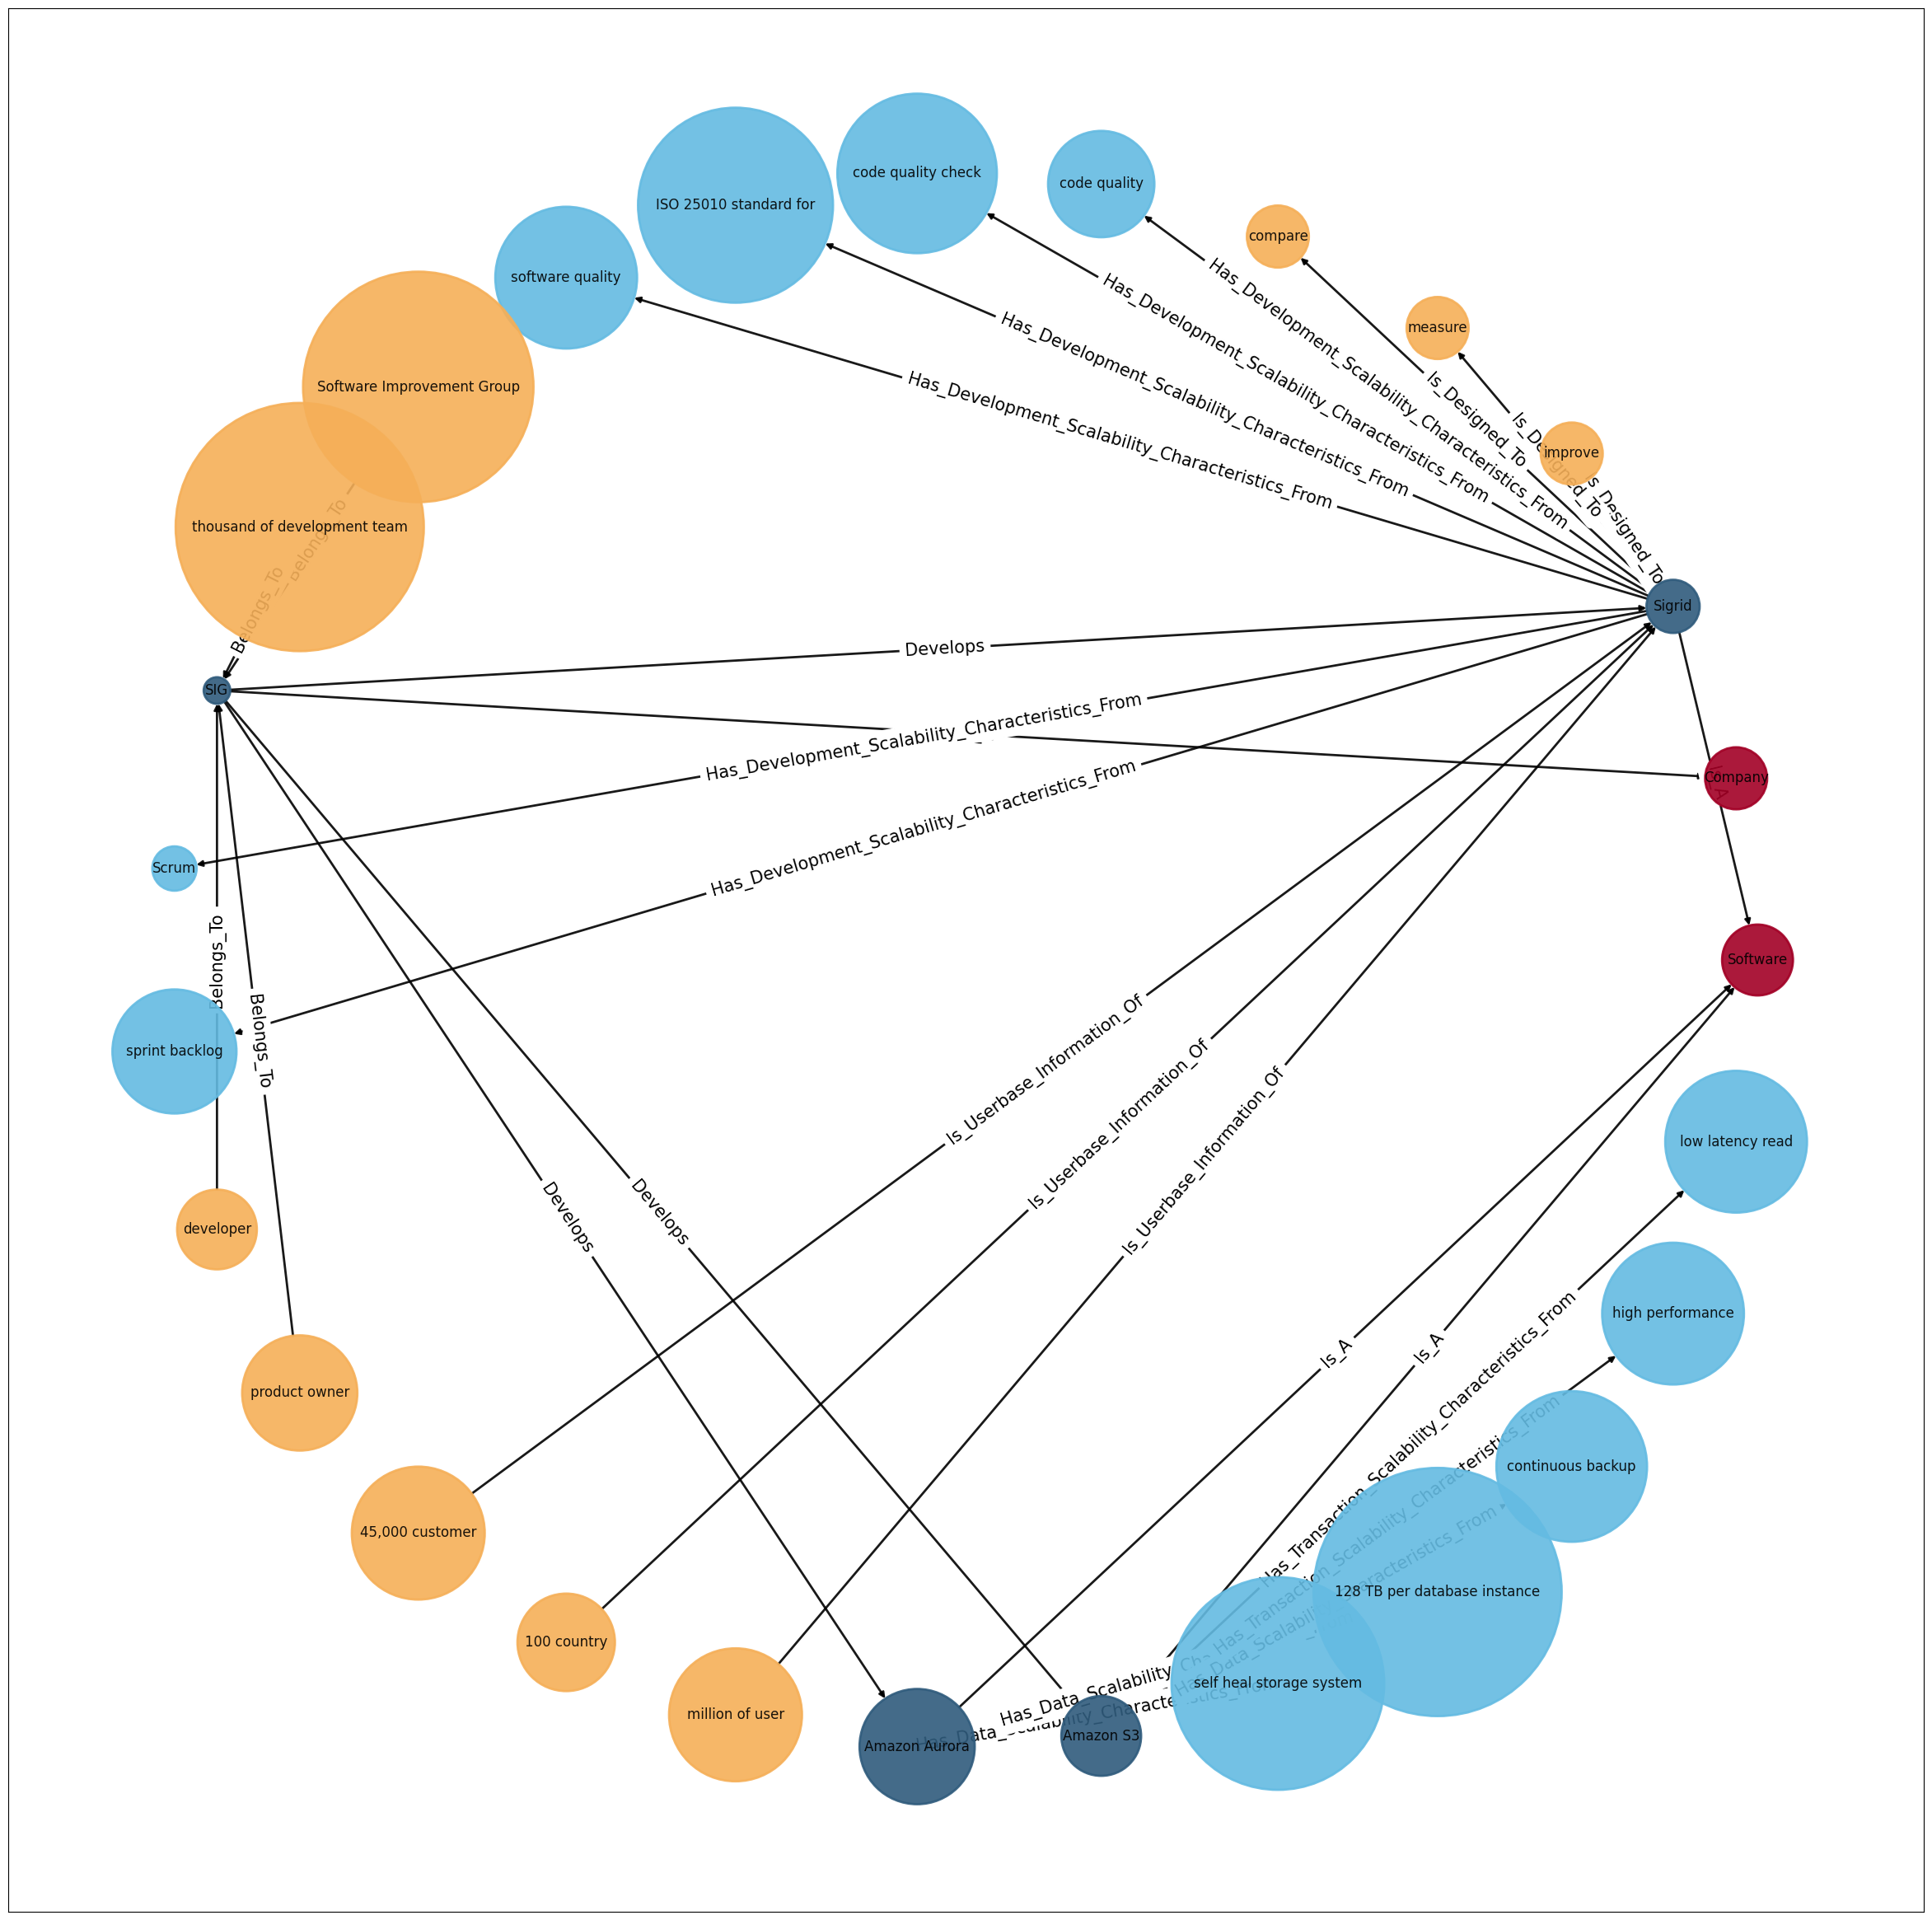

In [ ]:
# Compute the positions of nodes using the Kamada-Kawai layout algorithm
positions = nx.circular_layout(G)

# Extract the node information from the graph
nodes = list(G.nodes(data=True))

node_colors = [b['color'] for (a,b) in nodes]
labels = {node[0]: node[1].get('label', str(node[0])) for node in nodes}
node_sizes = [len(label) ** 2 * 60 for label in labels.values()]

# Plot the graph
plt.figure(figsize=(30, 30))
nx.draw_networkx(
    G,
    node_color=node_colors,
    pos=positions,
    labels=labels,
    node_size=node_sizes,
    edge_color='black', width=2, linewidths=2, alpha=0.9, font_size=12
)

nx.draw_networkx_edge_labels(G, pos=positions, edge_labels=edge_labels, font_size=15)

# Display the plot
plt.show()